<a href="https://colab.research.google.com/github/v4l3rio/NesGen/blob/main/NESGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the dataset

In [ ]:
#@title Get the full version of the Lakh MIDI Dataset v0.1
!wget http://hog.ee.columbia.edu/craffel/lmd/lmd_full.tar.gz
!tar xvf lmd_full.tar.gz
!rm lmd_full.tar.gz

dataset_path = "/content/lmd_full"

In [ ]:
#@title Get a smaller version of the Lakh MIDI Dataset v0.1
!wget http://hog.ee.columbia.edu/craffel/lmd/clean_midi.tar.gz
!tar xvf clean_midi.tar.gz
!rm clean_midi.tar.gz

dataset_path = "/content/clean_midi"

Output streaming troncato alle ultime 5000 righe.
clean_midi/Camaleonti/
clean_midi/Camaleonti/Eternita.mid
clean_midi/Camaleonti/Applausi.1.mid
clean_midi/Camaleonti/L'ora dell'amore.1.mid
clean_midi/Camaleonti/L'ora dell'amore.2.mid
clean_midi/Camaleonti/L'ora dell'amore.3.mid
clean_midi/Camaleonti/Mamma mia.2.mid
clean_midi/Camaleonti/Viso d'angelo.mid
clean_midi/Camaleonti/Io per lei.mid
clean_midi/Camaleonti/Mamma mia.mid
clean_midi/Camaleonti/Perche ti amo.1.mid
clean_midi/Camaleonti/Perche ti amo.mid
clean_midi/Camaleonti/L'ora dell'amore.mid
clean_midi/Camaleonti/Viso d'angelo.1.mid
clean_midi/Camaleonti/Applausi.mid
clean_midi/Camaleonti/Mamma mia.1.mid
clean_midi/Camaleonti/Cuore di vetro.mid
clean_midi/Mike + The Mechanics/
clean_midi/Mike + The Mechanics/Silent Running.mid
clean_midi/Mike + The Mechanics/Another Cup of Coffee.2.mid
clean_midi/Mike + The Mechanics/Over My Schoulder.mid
clean_midi/Mike + The Mechanics/All I Need Is a Miracle.mid
clean_midi/Mike + The Mechanic

In [ ]:
#@title Get the NESMDB dataset
!gdown 1gIli7G1wu0QWDLzRc-CPWB8C4Hu0XVn3
!unzip nesmdb_midi.zip
!rm nesmdb_midi.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: nesmdb_midi/test/265_PokerJ_ngl_ng_06_07Won.mid  
  inflating: nesmdb_midi/test/265_PokerJ_ngl_ng_07_08WonAgainstRukaFullHouseFrancine.mid  
  inflating: nesmdb_midi/test/265_PokerJ_ngl_ng_08_09WonAgainstMariDoubleDealingDebbie.mid  
  inflating: nesmdb_midi/test/265_PokerJ_ngl_ng_09_10WonAgainstAyamiPokerPenny.mid  
  inflating: nesmdb_midi/test/272_Quarth_00_01Setup.mid  
  inflating: nesmdb_midi/test/272_Quarth_01_02TheThemeofQuarth.mid  
  inflating: nesmdb_midi/test/272_Quarth_02_03TheMenaceoftheBlock.mid  
  inflating: nesmdb_midi/test/272_Quarth_03_04TheClosingGameintheUniverse.mid  
  inflating: nesmdb_midi/test/272_Quarth_04_05PatternClear.mid  
  inflating: nesmdb_midi/test/272_Quarth_05_06GameOver.mid  
  inflating: nesmdb_midi/test/272_Quarth_06_07Unknown.mid  
  inflating: nesmdb_midi/test/285_Route16Turbo_00_01Title.mid  
  inflating: nesmdb_midi/test/285_Route16Turbo_01_02Easy.mid  
  inflating: nesmdb_midi/t

# Utility functions

In [ ]:
def random_file(root, keyword=None):
    import glob
    import os
    import random
    mid_files = glob.glob(os.path.join(root, "**", "*.mid"), recursive=True)
    if keyword is not None:
      mid_files = [file for file in mid_files if keyword in file.lower()]
    return random.choice(mid_files)

# MIDI playing

## Installing the required libraries

In [ ]:
!apt-get update -qq && apt-get install -y fluidsynth
!pip install pretty_midi midi-clip

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 lib

## Download example Soundfonts (GeneralUser GS v2 and PICONICA)

In [ ]:
!gdown 1wlpTIS70nQHMrYBjDT0M6nyg07kUejUv
!unzip GeneralUser_GS_v2.0.0--doc_r2.zip
!rm -rf GeneralUser_GS_v2.0.0--doc_r2.zip support documentation demo\ MIDIs
!mv GeneralUser\ GS\ v2.0.0.sf2 guGS.sf2

# PICONICA
!gdown 1uk51T9Gvo1n2JRl3_CHCg2FVGWiNI4qJ

Downloading...
From (original): https://drive.google.com/uc?id=1wlpTIS70nQHMrYBjDT0M6nyg07kUejUv
From (redirected): https://drive.google.com/uc?id=1wlpTIS70nQHMrYBjDT0M6nyg07kUejUv&confirm=t&uuid=59745ddb-9f8a-465e-9fa5-3467e846b404
To: /content/GeneralUser_GS_v2.0.0--doc_r2.zip
100% 62.5M/62.5M [00:01<00:00, 58.2MB/s]
Archive:  GeneralUser_GS_v2.0.0--doc_r2.zip
   creating: demo MIDIs/
   creating: demo MIDIs/audio/
  inflating: demo MIDIs/audio/Bond.ogg  
  inflating: demo MIDIs/audio/Breakout.ogg  
  inflating: demo MIDIs/audio/Dance.ogg  
  inflating: demo MIDIs/audio/Earth Day - by Richard Audd (fixed).ogg  
  inflating: demo MIDIs/audio/J-cycle.ogg  
  inflating: demo MIDIs/audio/Jump!.ogg  
  inflating: demo MIDIs/audio/Santa Claus is Comin' to Town.ogg  
  inflating: demo MIDIs/audio/The HYBRID Collage (v2.0) - by S. Christian Collins.ogg  
  inflating: demo MIDIs/audio/Umi no Mieru Machi.ogg  
  inflating: demo MIDIs/Bond.mid     
  inflating: demo MIDIs/Breakout.mid  
  infla

## Optional: download other soundfonts

In [ ]:
# Pokemon
!gdown 1vDK_xH7WeAqQrrBFXfh4Q205x6oNhTQt

## Utility function to generate the audio on Colab

### Taken from https://github.com/bzamecnik/midi2audio/blob/master/midi2audio.py

In [ ]:
import argparse
import os
import subprocess

__all__ = ['FluidSynth']

DEFAULT_SOUND_FONT = '~/.fluidsynth/default_sound_font.sf2'
DEFAULT_SAMPLE_RATE = 44100
DEFAULT_GAIN = 0.2

class FluidSynth():
    def __init__(self, sound_font=DEFAULT_SOUND_FONT, sample_rate=DEFAULT_SAMPLE_RATE, gain=DEFAULT_GAIN):
        self.sample_rate = sample_rate
        self.sound_font = os.path.expanduser(sound_font)
        self.gain = gain

    def midi_to_audio(self, midi_file: str, audio_file: str, verbose=True):
        if verbose:
            stdout = None
        else:
            stdout = subprocess.DEVNULL
        subprocess.call(
            ['fluidsynth', '-ni', '-g', str(self.gain), self.sound_font, midi_file, '-F', audio_file, '-r', str(self.sample_rate)],
            stdout=stdout,
        )

    def play_midi(self, midi_file):
        subprocess.call(['fluidsynth', '-i', '-g', str(self.gain), self.sound_font, midi_file, '-r', str(self.sample_rate)])

### Other utility functions

In [ ]:
import pretty_midi
import os
import librosa.display

def show_midi_info(midi_path, print_notes=False):
  midi_data = pretty_midi.PrettyMIDI(midi_path)
  print("Instruments: ", [instrument.name for instrument in midi_data.instruments])
  print("MIDI duration: {duration:.2f} seconds".format(duration=midi_data.get_end_time()))
  if print_notes:
    for instrument in midi_data.instruments:
      print(instrument.name)
      for note in instrument.notes:
        print(note.start, note.end, note.pitch, note.velocity)

def piano_roll(midi_path):
  plt.figure(figsize=(12, 4))
  plot_piano_roll(path, 24, 84)

def plot_piano_roll(path, start_pitch, end_pitch, fs=100):
    midi_data = pretty_midi.PrettyMIDI(path)
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(midi_data.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

def change_midi_velocity(midi_path, output_path, delta=0): # Renamed the function to avoid name conflict
  midi_data = pretty_midi.PrettyMIDI(midi_path)
  if delta != 0:
    for instrument in midi_data.instruments:
      for note in instrument.notes:
        note.velocity += delta
    midi_data.write(output_path)

def convert_midi_to_wav(soundfont_path, midi_path, output_path, gain=None, velocity_change=0): # Renamed the argument
  change_midi_velocity(midi_path, "temp.mid", delta=velocity_change) # Call the renamed function
  FluidSynth(soundfont_path, gain=gain).midi_to_audio("temp.mid", output_path)
  os.remove("temp.mid")


def trim_midi(midi_path, start, end):
  import mido
  import midi_clip
  mid = mido.MidiFile(midi_path)
  trimmed_midi = midi_clip.midi_clip(mid, start, end)

  dir_name, base_name = os.path.split(midi_path)
  new_base_name = "trimmed_" + base_name
  output_path = os.path.join(dir_name, new_base_name)
  trimmed_midi.save(output_path)
  return output_path

def playMidi(midi_file_path,
             soundfont_path="/content/guGS.sf2",
             output_path="audio.wav",
             start=None,
             end=None,
             gain=DEFAULT_GAIN,
             velocity_change=0
             ):
    from IPython.display import Audio

    if start is not None and end is not None:
      midi_file_path = trim_midi(midi_file_path, start, end)
      convert_midi_to_wav(soundfont_path, midi_file_path, output_path, gain=gain, velocity_change=velocity_change)
      os.remove(midi_file_path)
    else:
      convert_midi_to_wav(soundfont_path, midi_file_path, output_path, gain=gain, velocity_change=velocity_change)
    return Audio(output_path)

Converting: /content/clean_midi/10cc/I'm Not In Love.2.mid
Midi info:
Instruments:  ['FINGERDBAS', 'CHOIR AAHS', 'MELODY', 'E.PIANO 1', 'VOICE OOHS', 'SYNVOX', 'CLEAN GTR', 'A.PIANO 1', 'DRUMS', 'GLOCKENSPL', 'ICE RAIN', 'FANTASIA']
MIDI duration: 367.07 seconds
FINGERDBAS
125.704128 126.45803533333333 F2 93
126.43819566666666 127.11274433333332 C2 93
127.132584 127.608736 A1 100
127.62857566666666 128.36264333333332 D2 110
129.03719199999998 129.57286299999998 D2 100
130.96163966666666 131.47747099999998 A1 110
132.88608733333334 133.42175833333332 A#1 110
134.751016 135.286687 C2 105
136.67546366666664 137.21113466666665 D2 107
140.42516066666667 141.000511 C2 100
142.38928766666666 142.92495866666667 C#2 86
144.29389566666666 144.82956666666666 D2 102
150.26563533333334 150.5632303333333 A2 93
150.72194766666667 151.01954266666667 G2 102
151.19809966666665 151.43617566666666 E2 91
151.69409133333332 151.91232766666664 D2 91
152.130564 152.36864 C2 100
152.60671599999998 152.90431099

<ipython-input-17-21fdabe764ec>:18: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(midi_data.get_piano_roll(fs)[start_pitch:end_pitch],


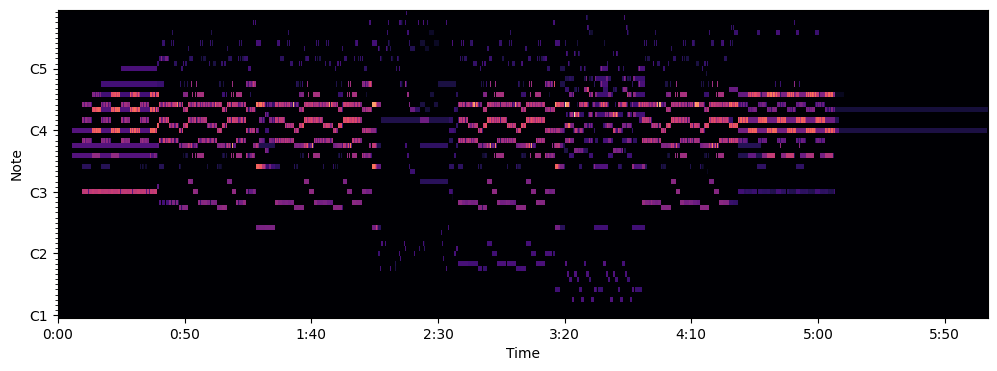

In [ ]:
import matplotlib.pyplot as plt

path = random_file(dataset_path)
print("Converting: " + path)
print("Midi info:")
show_midi_info(path)

## Play a random MIDI of the Lakh dataset

In [ ]:
path = random_file(dataset_path)
print("Converting: " + path)
print("Midi info:")
show_midi_info(path)
print("Synthetized:")
playMidi(path)

Converting: /content/clean_midi/Peter Gabriel/That Voice Again.mid
Midi info:
Instruments:  ['', '', '', '', '', '', '', '', 'Hi-Hat', 'Crash', 'Bass Drum', '', '', '', '', '', '', '', '', 'Melody']
MIDI duration: 266.00 seconds
Synthetized:


TypeError: 'int' object is not callable

## Play a random MIDI of the NESMDB dataset

In [ ]:
path = random_file("nesmdb_midi")
print("Converting: " + path)
print("Midi info:")
show_midi_info(path)
print("Synthetized:")
playMidi(path, soundfont_path="PICONICA.sf2", velocity_change=30, gain=1)

Converting: nesmdb_midi/train/213_MachRider_07_08Bonus2.mid
Midi info:
Instruments:  ['p1', 'p2', 'tr', 'no']
MIDI duration: 1.80 seconds
Synthetized:
